# Attempt to  process a CPN dataset containing 10 different sounds

In [19]:
from src.metrics.significance import _significance, _mask_with_significance
from src.metrics.consolidated_dprimes import _load_site_formated_raste,  single_cell_dprimes, probewise_LDA_dprimes, probewise_dPCA_dprimes, full_dPCA_dprimes
from src.metrics.dprime import flip_dprimes
from src.data.load import get_site_ids, set_name
from src.metrics.consolidated_metrics import metrics_to_DF, _append_means_to_array, _append_means_to_shuff_array
from src.data.region_map import region_map

import itertools as itt
import numpy as np
import pandas as pd
from configparser import ConfigParser
import pathlib as pl
from joblib import dump, load, Parallel, delayed
from src.root_path import root_path
import matplotlib.pyplot as plt
from src.visualization.fancy_plots import _raster, unit_line
from src.data.dPCA import _cpp_dPCA, format_raster
from cycler import cycler

In [20]:
config = ConfigParser()
config.read_file(open(root_path / 'config' / 'settings.ini'))

In [21]:
#general plottin formating
plt.style.use('dark_background')

light_color_cycle = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

trans_color_map = {'silence': '#377eb8',  # blue
                   'continuous': '#ff7f00',  # orange
                   'similar': '#4daf4a',  # green
                   'sharp': '#a65628'}  # brown

params = {'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': light_color_cycle,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [4,4],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial',
          'legend.loc': 'upper right',
          'legend.frameon': False,
          'legend.fontsize': 15,
          'legend.markerscale': 3,
          }

widescreen = [13.3, 7.5]

plt.rcParams.update(params)

In [8]:
rec_recache = False
dprime_recache = False

signif_tails = 'both'
alpha=0.05

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations'}

expt = {'contexts': list(range(11)),
        'probes': list(range(1,11))}



## example site loaded

In [9]:
example_site = 'TNC018a'
dprime, shuffled_dprime, goodcells, var_capt = full_dPCA_dprimes(example_site, **expt, meta=meta)

print(f'dprime: {dprime.shape}, shuffled: {shuffled_dprime.shape}')


## run all sites
parallelized and chached

In [50]:
# run in parallel all 10sound sites, this will take a while
siteids = ['TNC013a', 'TNC014a', 'TNC015a', 'TNC016a', 'TNC017a', 'TNC018a']

_ = Parallel(n_jobs=4)(delayed(full_dPCA_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)

print('done')

done


In [51]:
_ = Parallel(n_jobs=4)(delayed(probewise_dPCA_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)

print('done')

done


In [52]:
# fails due to RAM liminations

_ = Parallel(n_jobs=4)(delayed(single_cell_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)




MemoryError: Unable to allocate 24.6 GiB for an array with shape (1000, 20, 50, 11, 10, 30) and data type float64

In [53]:
def load_all_raw_data(id, fulldpca=True):

    # def analysis_steps_plot(id, probe):
    site = id[:7]
    if len(id) == 7:
        population = True
    else:
        population = False

    # loads the raw data
    raster, goodcells = _load_site_formated_raste(site, **expt, meta=meta)
    trialR, R, _ = format_raster(raster)

    if population and fulldpca:
        _, trialZ, dpca = _cpp_dPCA(R, trialR)
        trialR = trialZ['ct'][:, 0, ...][:,None,...]
        dprime, shuffled_dprime, goodcells, dPCA = full_dPCA_dprimes(site, **expt, meta=meta)

    elif population and not fulldpca:
        r, n, c, p, t = trialR.shape
        trialZ = np.empty((r, 1, c, p, t))
        for probe_idx in range(p):
            probe_trialR = trialR[..., probe_idx, :]
            probe_R = R[..., probe_idx, :]

            # calculates dPCA considering all 4 categories
            _, probe_trialZ, _ = _cpp_dPCA(probe_R, probe_trialR)
            trialZ[:, :, :, probe_idx, :] = probe_trialZ['ct'][:, 0, ...][:,None,...]

        trialR = trialZ
        dprime, shuffled_dprime, goodcells, dPCA = probewise_dPCA_dprimes(site, **expt, meta=meta)

    else:
        dprime, shuffled_dprime, goodcells, dPCA = single_cell_dprimes(site, **expt, meta=meta)


    dprime, shuffled_dprime = flip_dprimes(dprime, shuffled_dprime, flip='sum')
    significance, confidence_interval = _significance(dprime, shuffled_dprime, [3], 3, alpha=alpha)

    t =  np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                            endpoint=False) * 1000

    return trialR, dprime, shuffled_dprime, significance, confidence_interval, goodcells, t



In [54]:
# todo make more general by omiting the cell and  probe id and instead passing the correct array slice
# PSTH and raster on the diagonal
def single_psth(trialR, cell_idx, trans_idx, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx, probe_idx, :].mean(axis=0), color=f'C{trans_idx}',
                     linewidth=3)
    return ax

def single_raster(trialR, cell_idx, trans_idx, probe_idx, ax):
    # plot raster only for single cells
    _ = _raster(t, trialR[:, cell_idx, trans_idx, probe_idx, :], y_offset=0, y_range=ax.get_ylim(), ax=ax,
                         scatter_kws={'color': f'C{trans_idx}', 'alpha': 0.4, 's': 10})
    return ax

# Paired PSTHs on the upper triangle
def double_psth(trialR, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx_0, probe_idx, :].mean(axis=0), color=f'C{trans_idx_0}',
                     linewidth=3)

    ax.plot(t, trialR[:, cell_idx, trans_idx_1, probe_idx, :].mean(axis=0), color=f'C{trans_idx_1}',
                     linewidth=3)
    return ax

# dprime plus CI on the lower triangle
def dprime_ci(dprime, confidence_interval, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    trans_pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(expt['contexts'], 2)
                      ].index(f'{trans_idx_0}_{trans_idx_1}')
    ax.plot(t, dprime[cell_idx, trans_pair_idx, probe_idx, :], color='white')
    ax.fill_between(t, confidence_interval[0, cell_idx, trans_pair_idx, probe_idx, :],
                    confidence_interval[1, cell_idx, trans_pair_idx, probe_idx, :],
                    color='white', alpha=0.5)
    return ax

# iterates over the grid
def grid_plot(id, trialR, dprime, confidence_interval, probe):

    cell_idx = goodcells.index(id) if len(id)>7 else 0
    probe_idx = expt['probes'].index(probe)

    fig = plt.figure(figsize=(8,8))

    n_ctx = trialR.shape[2] # Reps x Neurons x Contexts x Probex x TimePoints
    gs = fig.add_gridspec(n_ctx,n_ctx)

    first_up = True
    first_lo = True

    diagonals = list()
    for x, y in itt.product(range(n_ctx),range(n_ctx)):

        # creates subplots with shared x axis for the diagonal and upper triangle
        if x <= y:
            if first_up:
                upax = fig.add_subplot(gs[x,y])
                ax = upax
                first_up = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=upax)
        else:
            if first_lo:
                loax = fig.add_subplot(gs[x,y])
                ax = loax
                first_lo = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=loax)

        # plots upper triangle psth
        if x < y:
            _ = double_psth(trialR, cell_idx, x, y, probe_idx, ax)


        #plots lower triangle dprime
        elif x > y:
            _ = dprime_ci(dprime, confidence_interval, cell_idx, y, x, probe_idx, ax)

        # plots diagonal raster
        else:
            _ = single_psth(trialR, cell_idx, x, probe_idx, ax)
            diagonals.append(ax)

        # removes time tick labels
        if x != n_ctx-1:
            plt.setp(ax.get_xticklabels(), visible=False)

        # add time labels
        else:
            if y == int(n_ctx/2):
                ax.set_xlabel('time (ms)')

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # removes y tick lables
        if y not in [0,n_ctx-1]:
            plt.setp(ax.get_yticklabels(), visible=False)

        # remove y labels on the first psth
        if y == 0 and x == 0:
            plt.setp(ax.get_yticklabels(), visible=False)

        # dprime labels on left side
        if y == 0 and x == int(n_ctx/2):
            ax.set_ylabel("contextual effects discriminability (d')")

        # zscore firing rate ticks on right side
        if y == n_ctx-1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            if x == int(n_ctx/2):
                ax.set_ylabel('firing rate (z-score)')
            ax.spines['right'].set_visible(True)

    if len(id)>7:
        for n, ax in enumerate(diagonals):
            _ =single_raster(trialR, cell_idx, n, probe_idx, ax)
    else:
        for n, ax in enumerate(diagonals):
            ax.axhline(0, color='white', linestyle='--')

    return fig


## probewise dPCA example for best site and probe

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC018a_38a8c51bbfde8def275064f479df65378df73507.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.evp


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.006640873038344959
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.
You chose to determine the regularization parameter

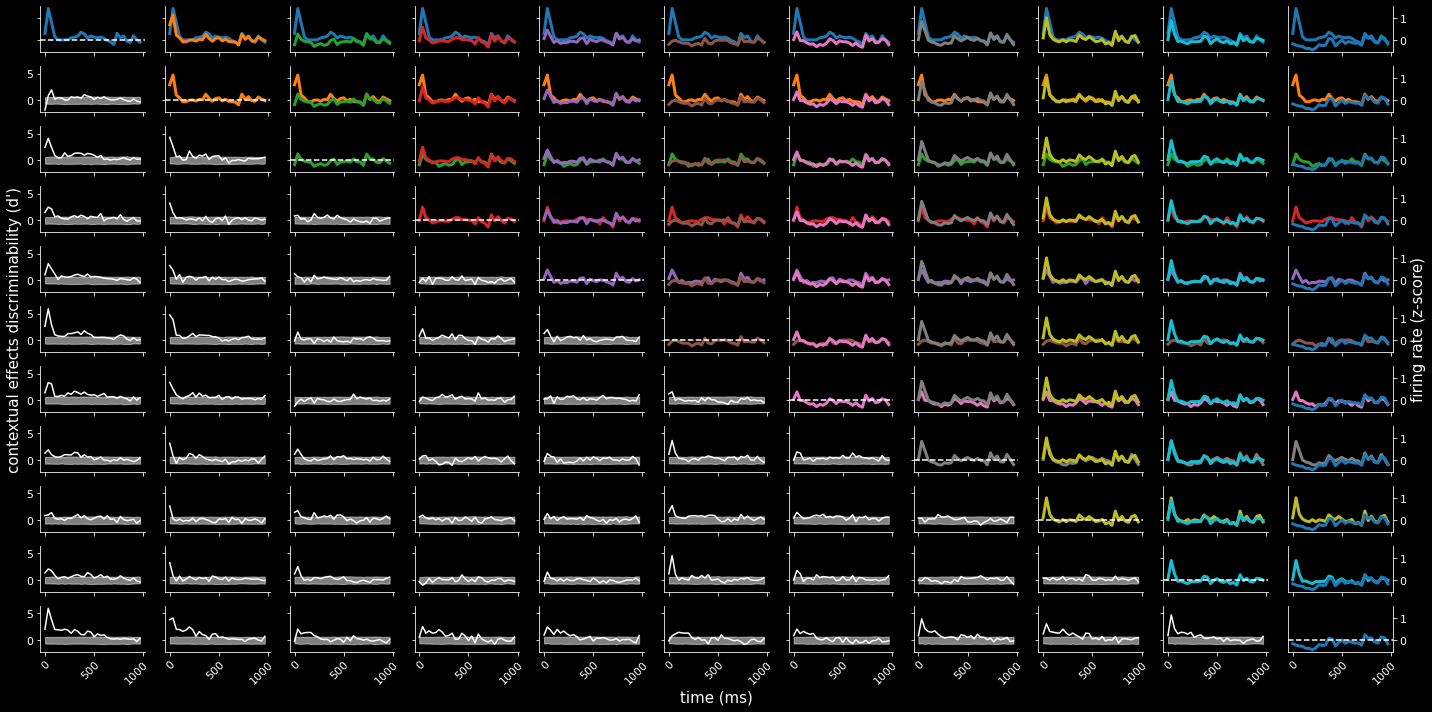

In [55]:
trialR, dprime, shuffled_dprime, significance, confidence_interval, goodcells, t = load_all_raw_data(example_site, fulldpca=False)
fig = grid_plot(example_site, trialR, dprime, confidence_interval, 5)
fig.set_size_inches(20,10)
title =f'context_pair_grid_{example_site}'


## full dPCA example for best site and probe

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC018a_38a8c51bbfde8def275064f479df65378df73507.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.evp


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.0017286737396774677
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


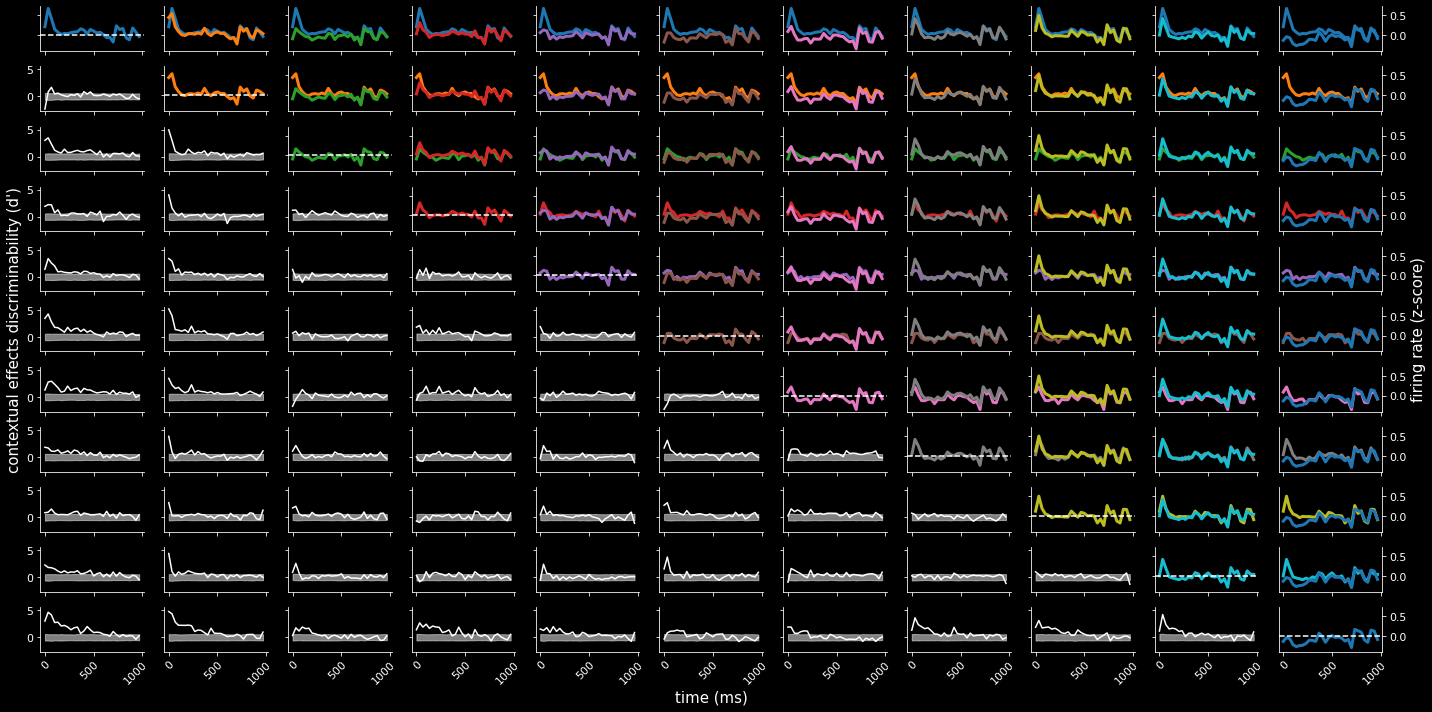

In [56]:
trialR, dprime, shuffled_dprime, significance, confidence_interval, goodcells, t = load_all_raw_data(example_site, fulldpca=True)
fig = grid_plot(example_site, trialR, dprime, confidence_interval, 5)
fig.set_size_inches(20,10)
title =f'context_pair_grid_{example_site}'


In [49]:
# determines the max dprime to plot examples

# maxes = dict()
# for site in siteids:
#     dprime,_,_,_, = full_dPCA_dprimes(site, **expt, meta=meta)
#
#
#     maxidx = np.where(np.abs(dprime) == np.max(np.abs(dprime)))
#     print(f'{site}, {maxidx}, {dprime[maxidx]}')
#     maxes[site] = maxidx
# #